![hopsworks_logo](../../images/hopsworks_logo.png)

# Part 01: Load, Engineer & Connect

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_batch/1_feature_groups.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

In this series of tutorials we will work with data related to NYC taxi fares. The end goal is to train and serve a model on the Hopsworks platform that can predict the trip price.


## 🗒️ This notebook is divided in 3 sections:
1. Loading the data and feature engineeing,
2. Connect to the Hopsworks feature store,
3. Create feature groups and upload them to the feature store.

![01_featuregroups](../../images/01_featuregroups.png)

***

#### <span style="color:#ff5f27;"> 📝 Importing Libraries</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import hashlib
from datetime import datetime

## <span style="color:#ff5f27;"> ⬇️ Loading Datasets</span>

In [3]:
df_rides = pd.read_csv("https://raw.githubusercontent.com/rktraz/NYC-Taxi-Fares-Tutorial/main/rides.csv", 
                       index_col=0, parse_dates=["pickup_datetime"])
df_rides.head(5)

,ride_id,is_start,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
0,1228,True,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194
1,527,True,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122
2,394,True,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102
3,1366,True,1577907320000,0,-73.860565,40.768370,-73.819430,40.820730,3,2013000059,2013000059
4,1085,True,1577901700000,0,-73.831210,40.805737,-73.782560,40.867650,3,2013000064,2013000064


In [4]:
df_fares = pd.read_csv("https://raw.githubusercontent.com/rktraz/NYC-Taxi-Fares-Tutorial/main/fares.csv", 
                       index_col=0, parse_dates=["pickup_datetime"])
df_fares.head(5)

,ride_id,taxi_id,driver_id,pickup_datetime,payment_type,tip,tolls,total_fare
0,1,2013000185,2013000185,1577880020,CASH,33.0,0.0,118.0
1,2,2013000108,2013000108,1577880040,CARD,14.0,0.0,48.0
2,3,2013000134,2013000134,1577880060,CASH,12.0,0.0,41.0
3,4,2013000062,2013000062,1577880080,CARD,13.0,0.0,44.0
4,5,2013000087,2013000087,1577880100,CASH,14.0,0.0,46.0


***

## <span style="color:#ff5f27;">  🛠 EDA and Feature Engineering</span>

### <span style="color:#ff5f27;">🔬 df_rides</span>

In [5]:
df_rides.dtypes

ride_id                int64
is_start                bool
pickup_datetime       object
dropoff_datetime       int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
taxi_id                int64
driver_id              int64
dtype: object

In [6]:
df_rides.pickup_datetime

0        1577904560000
1        1577890540000
2        1577887880000
3        1577907320000
4        1577901700000
             ...      
41073    1578696720000
41074    1578692780000
41075    1578698180000
41076    1578697460000
41077    1578697620000
Name: pickup_datetime, Length: 41078, dtype: object

In [7]:
df_rides.head(3)

,ride_id,is_start,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
0,1228,True,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194
1,527,True,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122
2,394,True,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102


In [8]:
df_rides.dropoff_datetime.unique(), df_rides.is_start.unique()

(array([0], dtype=int64), array([ True]))

As we can see, 'dropoff_datetime' and 'is_start' columns do not give us any useful info. We will drop them.

In [9]:
df_rides = df_rides.drop(columns=["dropoff_datetime", "is_start"])

In [10]:
df_rides.shape

(41078, 9)

In [11]:
df_rides.describe()

,ride_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
count,41078.000000,41078.000000,41078.000000,41078.000000,41078.000000,41078.000000,4.107800e+04,4.107800e+04
mean,20539.500000,-73.874513,40.750620,-73.874596,40.750514,2.503238,2.013000e+09,2.013000e+09
std,11858.341516,0.068350,0.086990,0.068332,0.086967,0.513021,5.773362e+01,5.773362e+01
min,1.000000,-74.140670,40.411880,-74.140670,40.411880,1.000000,2.013000e+09,2.013000e+09
25%,10270.250000,-73.921960,40.690235,-73.922005,40.690175,2.000000,2.013000e+09,2.013000e+09
50%,20539.500000,-73.874306,40.750890,-73.874468,40.750676,3.000000,2.013000e+09,2.013000e+09
75%,30808.750000,-73.827060,40.811023,-73.827156,40.810890,3.000000,2.013000e+09,2.013000e+09
max,41078.000000,-73.603760,41.095210,-73.603760,41.095210,4.000000,2.013000e+09,2.013000e+09


***

#### <span style="color:#ff5f27;">💡 Dealing with distance metrics</span>

In [12]:
# minimum and maximum longitude
min(df_rides.pickup_longitude.min(), df_rides.dropoff_longitude.min()), \
max(df_rides.pickup_longitude.max(), df_rides.dropoff_longitude.max())

(-74.14067, -73.60376)

In [13]:
# minimum and maximum longitude
min(df_rides.pickup_latitude.min(), df_rides.dropoff_latitude.min()), \
max(df_rides.pickup_latitude.max(), df_rides.dropoff_latitude.max())

(40.41188, 41.09521)

##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Let's select rides that were perfomed inside NYC geographically** </a>


In [14]:
# a function for selecting rows that are inside some bounding box
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# NYC coordinates bounding box
BB = (-74.5, -72.8, 40.5, 41.8)

In [15]:
print('Old size: %d' % len(df_rides))
df_rides = df_rides[select_within_boundingbox(df_rides, BB)]
print('New size: %d' % len(df_rides))

Old size: 41078
New size: 40907


##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Now we will add a new column that represents distance of rides (in miles).** </a>


In [16]:
# returns distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [17]:
df_rides.columns

Index(['ride_id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'taxi_id',
       'driver_id'],
      dtype='object')

In [18]:
df_rides["distance"] = distance(df_rides["pickup_latitude"], df_rides["pickup_longitude"],
                            df_rides["dropoff_latitude"], df_rides["dropoff_longitude"])

In [19]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468


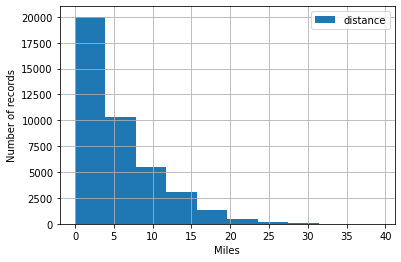

In [20]:
df_rides.distance.hist(legend=True)
plt.xlabel('Miles')
plt.ylabel('Number of records')
plt.show()

##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Let us add usefull features about distances to NYC airports.** </a>



In [21]:
# Distances to nearby airports
jfk = (-73.7781, 40.6413)
ewr = (-74.1745, 40.6895)
lgr = (-73.8740, 40.7769)

df_rides['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                     df_rides['pickup_latitude'], df_rides['pickup_longitude'])
df_rides['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                       df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])
df_rides['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], 
                                      df_rides['pickup_latitude'], df_rides['pickup_longitude'])
df_rides['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],
                                       df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])
df_rides['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                      df_rides['pickup_latitude'], df_rides['pickup_longitude'])
df_rides['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                       df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])


In [22]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822,9.408176,9.593451,16.774843,17.047352,1.258733,1.037595
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499,9.982850,13.547285,17.587239,21.721546,0.929374,5.375477
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468,10.781049,17.111724,18.603343,25.423662,1.764932,9.574572


***

#### <span style="color:#ff5f27;">⏱ Dealing with datetime</span>

In [23]:
df_rides["pickup_datetime"] = (pd.to_datetime(df_rides["pickup_datetime"],unit='ms'))

##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Now we need to save datetime in the proper format.** </a>

##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Adding additional time features.** </a>


In [24]:
df_rides['year'] = df_rides.pickup_datetime.apply(lambda t: t.year)
df_rides['weekday'] = df_rides.pickup_datetime.apply(lambda t: t.weekday())
df_rides['hour'] = df_rides.pickup_datetime.apply(lambda t: t.hour)

##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Make a new `month_of_the_ride` column for *partition_key* (this is all for Feature Group creating).** </a>



In [25]:
df_rides["month_of_the_ride"] = df_rides["pickup_datetime"].dt.strftime('%Y%m')

##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Convert a `pickup_datetime` back to UNIX format.** </a>

In [26]:
df_rides["pickup_datetime"] = df_rides["pickup_datetime"].values.astype(np.int64) // 10 ** 6

In [27]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,year,weekday,hour,month_of_the_ride
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822,9.408176,9.593451,16.774843,17.047352,1.258733,1.037595,2020,2,18,202001
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499,9.982850,13.547285,17.587239,21.721546,0.929374,5.375477,2020,2,14,202001
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468,10.781049,17.111724,18.603343,25.423662,1.764932,9.574572,2020,2,14,202001


***

### <span style="color:#ff5f27;">🔬 df_fares</span>

In [28]:
df_fares.head(3)

,ride_id,taxi_id,driver_id,pickup_datetime,payment_type,tip,tolls,total_fare
0,1,2013000185,2013000185,1577880020,CASH,33.0,0.0,118.0
1,2,2013000108,2013000108,1577880040,CARD,14.0,0.0,48.0
2,3,2013000134,2013000134,1577880060,CASH,12.0,0.0,41.0


In [29]:
df_fares.dtypes

ride_id              int64
taxi_id              int64
driver_id            int64
pickup_datetime     object
payment_type        object
tip                float64
tolls              float64
total_fare         float64
dtype: object

In [30]:
df_rides.shape

(40907, 20)

In [31]:
df_fares.shape

(41078, 8)

##### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Droping useless features.** </a>

In [32]:
df_fares.payment_type.unique()

array(['CASH', 'CARD'], dtype=object)

In [33]:
df_fares = df_fares.drop(columns=["pickup_datetime", "payment_type"])

In [34]:
df_fares.head(3)

,ride_id,taxi_id,driver_id,tip,tolls,total_fare
0,1,2013000185,2013000185,33.0,0.0,118.0
1,2,2013000108,2013000108,14.0,0.0,48.0
2,3,2013000134,2013000134,12.0,0.0,41.0


In [35]:
df_fares.describe()

,ride_id,taxi_id,driver_id,tip,tolls,total_fare
count,41078.000000,4.107800e+04,4.107800e+04,41078.000000,41078.000000,41078.000000
mean,20539.500000,2.013000e+09,2.013000e+09,16.155363,0.250426,59.510030
std,11858.341516,5.773362e+01,5.773362e+01,10.901697,0.782238,37.489159
min,1.000000,2.013000e+09,2.013000e+09,0.000000,0.000000,3.000000
25%,10270.250000,2.013000e+09,2.013000e+09,7.000000,0.000000,29.000000
50%,20539.500000,2.013000e+09,2.013000e+09,15.000000,0.000000,54.000000
75%,30808.750000,2.013000e+09,2.013000e+09,23.000000,0.000000,83.000000
max,41078.000000,2.013000e+09,2.013000e+09,60.000000,5.000000,218.000000


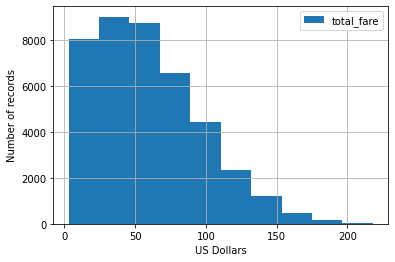

In [36]:
df_fares.total_fare.hist(legend=True)
plt.xlabel('US Dollars')
plt.ylabel('Number of records')
plt.show()

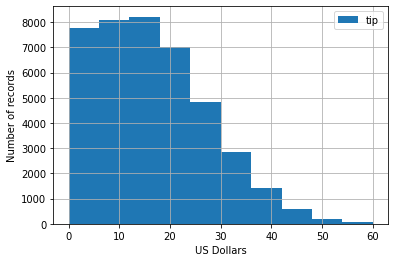

In [37]:
df_fares.tip.hist(legend=True)
plt.xlabel('US Dollars')
plt.ylabel('Number of records')
plt.show()

***

## <span style="color:#ff5f27;">🗳 Register feature groups</span>

### <span style="color:#ff5f27;">Instantiate a connection and get the `project` feature store handler</span>

In [38]:
!pip install -U hopsworks --quiet

In [39]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/164


Connected. Call `.close()` to terminate connection gracefully.


### <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **Creating Feature Groups** </a>

In [40]:
df_fares.head(3)

,ride_id,taxi_id,driver_id,tip,tolls,total_fare
0,1,2013000185,2013000185,33.0,0.0,118.0
1,2,2013000108,2013000108,14.0,0.0,48.0
2,3,2013000134,2013000134,12.0,0.0,41.0


In [41]:
df_fares.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41078 entries, 0 to 41077
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ride_id     41078 non-null  int64  
 1   taxi_id     41078 non-null  int64  
 2   driver_id   41078 non-null  int64  
 3   tip         41078 non-null  float64
 4   tolls       41078 non-null  float64
 5   total_fare  41078 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 2.2 MB


> **✂️ Let's split our `df_fares1` into 2 parts - the first one will be used in creating the Feature Group and the another one will be inserted in the existing Feature Group later in this tutorial.**

In [42]:
df_fares1 = df_fares.iloc[:30000]

df_fares2 = df_fares.iloc[30000:]

In [43]:
fares_fg = fs.get_or_create_feature_group(name="fares_fg",
                                          version=1,
                                          primary_key=["ride_id"], 
                                          description="Taxi fares features",
                                          time_travel_format="HUDI",  
                                          online_enabled=True,
                                          statistics_config={
                                              "enabled": False, "histograms": False,
                                              "correlations": False, "exact_uniqueness": False
                                          })   
fares_fg.insert(df_fares1)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/164/fs/106/fg/596


Uploading Dataframe: 0.00% |          | Rows 0/30000 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/164/jobs/named/fares_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x28169cb4a60>, None)

In [44]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,year,weekday,hour,month_of_the_ride
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822,9.408176,9.593451,16.774843,17.047352,1.258733,1.037595,2020,2,18,202001
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499,9.982850,13.547285,17.587239,21.721546,0.929374,5.375477,2020,2,14,202001
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468,10.781049,17.111724,18.603343,25.423662,1.764932,9.574572,2020,2,14,202001


In [45]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40907 entries, 0 to 41077
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ride_id                  40907 non-null  int64  
 1   pickup_datetime          40907 non-null  int64  
 2   pickup_longitude         40907 non-null  float64
 3   pickup_latitude          40907 non-null  float64
 4   dropoff_longitude        40907 non-null  float64
 5   dropoff_latitude         40907 non-null  float64
 6   passenger_count          40907 non-null  int64  
 7   taxi_id                  40907 non-null  int64  
 8   driver_id                40907 non-null  int64  
 9   distance                 40907 non-null  float64
 10  pickup_distance_to_jfk   40907 non-null  float64
 11  dropoff_distance_to_jfk  40907 non-null  float64
 12  pickup_distance_to_ewr   40907 non-null  float64
 13  dropoff_distance_to_ewr  40907 non-null  float64
 14  pickup_distance_to_lgr

In [46]:
rides_fg = fs.get_or_create_feature_group(name="rides_fg",
                                   version=1,
                                   primary_key=["ride_id"],
                                   event_time=["pickup_datetime"],                                   
                                   partition_key=["month_of_the_ride"],         
                                   description="Rides features",
                                   time_travel_format="HUDI",     
                                   online_enabled=True,                                                
                                   statistics_config={"enabled": False, "histograms": False, "correlations": False, "exact_uniqueness": False})   
rides_fg.insert(df_rides)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/164/fs/106/fg/597


Uploading Dataframe: 0.00% |          | Rows 0/40907 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/164/jobs/named/rides_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x28169c60460>, None)

***

## <span style="color:#ff5f27;"> ⚖️ Great Expectations </span> 

Great Expectations’ built-in library includes more than 50 common Expectations, such as:

    expect_column_values_to_not_be_null

    expect_column_values_to_be_unique

    expect_column_median_to_be_between...

#### You can find more expectations in the [official docs](https://greatexpectations.io/expectations/)


Clean, high quality feature data is of paramount importance to being able to train and serve high quality models. Hopsworks offers integration with [Great Expectations](https://greatexpectations.io/) to enable a smooth data validation workflow.

### `More info` - [here](https://docs.hopsworks.ai/3.0/user_guides/fs/feature_group/data_validation/)

In [47]:
!pip install -U great_expectations --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hsfs 3.0.0 requires great-expectations==0.14.3, but you have great-expectations 0.15.18 which is incompatible.


In [48]:
import great_expectations as ge

# Create (or import an existing) expectation suite using the Great Expectations library.
expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="validate_on_insert_suite"
)

> You can attach at most **one expectation suite** to a Feature Group. It can be done **on creation** or at a **later point in time**. Data validation is an **optional step** and is not required to write to a Feature Group.

***

## <span style="color:#ff5f27;"> ✔️✔️✖️ Lets create a couple of Expectations </span> 

In [49]:
df_fares2.total_fare.describe()

count    11078.000000
mean        58.378047
std         35.646164
min          3.000000
25%         28.000000
50%         55.000000
75%         82.000000
max        217.000000
Name: total_fare, dtype: float64

In [50]:
# here we define column to which we gonna apply an expectation
SELECTED_COLUMN = "total_fare"

In [51]:
# lets add an expecation to the 'total_fare' column
expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column": SELECTED_COLUMN,
            "min_value": 0,
            "max_value": 500
        }
    )
)

# you can add as many expectations (to the different columns in the same time) as you want

# let's for demonstration purposes make an expectation that will definitely fail
expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_median_to_be_between",
        kwargs={
            "column": SELECTED_COLUMN,
            "min_value": 0,
            "max_value": 1
        }
    )
)


{"expectation_type": "expect_column_median_to_be_between", "kwargs": {"column": "total_fare", "min_value": 0, "max_value": 1}, "meta": {}}

> You can provide **'expectation_suite' argument while creating a new Feature Group**. And then **insert new data** like usual, validation will run automatically.

In [52]:
new_feature = fs.get_or_create_feature_group(
    name="test_fg",
    version=1,
    description="Test data",
    primary_key=['index'],
    online_enabled=True,
    # Uncomment below to attach a GE suite when creating this Feature Group
    # expectation_suite=expectation_suite
)

***

### <span style="color:#ff5f27;"> ⬆️ Here we will save an Expectation Suite to the existing Feature Group </span> 

In [53]:
# Using Great Expectations Profiler

ge_profiler = ge.profile.BasicSuiteBuilderProfiler()
expectation_suite_profiler, _ = ge_profiler.profile(ge.from_pandas(df_fares2)) # here we pass a DataFrame to validate

Profiling Columns:   0%|          | 0/6 [00:00<?, ?it/s, ride_id]

2022-08-16 21:10:25,973 INFO: 	22 expectation(s) included in expectation_suite.


In [54]:
# here we retrieve our 'trans_fraud_online_fg' Feature Group from the Feature Store
fares_fg = fs.get_or_create_feature_group(
    name="fares_fg",
    version=1
)

In [55]:
# lets attach an expectation suite to your Feature Group.
# It enables persistence of the expectation suite to the Hopsworks backend.
fares_fg.save_expectation_suite(expectation_suite)

Attached expectation suite to featuregroup, edit it at https://c.app.hopsworks.ai:443/p/164/fs/106/fg/596


Here they are

![expectations_nyc.png](../../images/expectations_nyc.png)

> **❗️ Note that the expectation suite object is modified in place to populate it with necessary information to further upload validation reports. This suite can easily be retrieved during a different session or deleted whenever you are working with this Feature Group by calling:**

In [56]:
# # we can retrieve the expectation suite very simply
# ge_expectation_suite = fares_fg.get_expectation_suite()

# # or delete with
# trans_fg.drop_expectation_suite()

***

### <span style="color:#ff5f27;"> ⬆️ Upload Validation Reports to Hopsworks</span> 

When running validation using `Great Expectations`, a **validation report** is generated containing all validation results for the different expectations. Each result provides information about whether the provided DataFrame conforms to the corresponding expectation. These reports can be stored in Hopsworks to save a validation history for the data written to a particular Feature Group.

The **validation report** will be created each time you insert new data into Feature Group.

And you also can save the validation report of some batch of data without inserting the data:

In [57]:
# # As validation objects returned by Hopsworks are native Great Expectation objects, 
# # you can run validation using the usual Great Expectations syntax:
# ge_df = ge.from_pandas(df_fares2, expectation_suite=fares_fg.get_expectation_suite())
# ge_report = ge_df.validate()

2022-08-16 21:10:27,015 INFO: 	2 expectation(s) included in expectation_suite.


In [58]:
# #This will run the validation using the expectation suite attached to this Feature Group
# # and raise an exception if no attached suite is found.
# ge_report = fares_fg.validate(df_fares2)

# # # set the save_report parameter to False to skip uploading the report to Hopsworks
# # ge_report = fg.validate(df, save_report=False)

2022-08-16 21:10:27,399 INFO: 	2 expectation(s) included in expectation_suite.


In [59]:
# # upload the report to the Feature Store
# fares_fg.save_validation_report(ge_report)

A summary of these reports is available via an API call or in the Hopsworks UI enabling easy monitoring.

![expectations_nyc_res.png](../../images/expectations_nyc_res.png)

### <span style="color:#ff5f27;"> ⬆️ Insert new data to the Feature Store</span> 

In [60]:
# it will make new validation report for this batch of data, save the report and insert data into FG
fares_fg.insert(df_fares2)

2022-08-16 21:10:27,700 INFO: 	2 expectation(s) included in expectation_suite.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/164/fs/106/fg/596


Uploading Dataframe: 0.00% |          | Rows 0/11078 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/164/jobs/named/fares_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x28169cc48b0>,
 {
   "evaluation_parameters": {},
   "statistics": {
     "evaluated_expectations": 2,
     "successful_expectations": 1,
     "unsuccessful_expectations": 1,
     "success_percent": 50.0
   },
   "success": false,
   "meta": {
     "great_expectations_version": "0.14.3",
     "expectation_suite_name": "validate_on_insert_suite",
     "run_id": {
       "run_name": null,
       "run_time": "2022-08-16T19:10:27.699789+00:00"
     },
     "batch_kwargs": {
       "ge_batch_id": "16bae9df-1d97-11ed-ba22-14abc5f42df5"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20220816T191027.698790Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.14.3"
     }
   },
   "results": [
     {
       "result": {
         "observed_value": 55.0,
         "element_count": 11078,
         "missing_count": null,
         "missing_percent": null
       },
       "success": false,
       "expectation_config

---

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02 </span>

In the following notebook you will use our feature groups to create a dataset you can train a model on.